# Ice Floe Tracker data quality and consistency
We examine here whether aspects of the data are consistent year-to-year.

* Raw floes issue: matching on floe_id not ideal leads to area mismatch between the unmatched floes.
  * What data is getting misaligned from this? Is it possible to use the label for matching?
* Figures for data quality: drift speed distributions, maps
  * Some trajectories with no motion are still retained.

In [1]:
import pandas as pd
import numpy as np
import proplot as pplt

In [2]:
dataloc = '/Volumes/Research/ENG_Wilhelmus_Shared/group/IFT_fram_strait_dataset/'

ift_dfs = {}
for year in range(2003, 2021):
    ift_dfs[year] = pd.read_csv(dataloc + 'fram_strait-{y}/ift_clean_floe_properties_{y}.csv'.format(y=year))
    ift_dfs[year]['init_classification'] = ift_dfs[year]['init_classification'].fillna('NA')
    ift_dfs[year]['datetime'] = pd.to_datetime(ift_dfs[year].datetime.values)
    

There are still some places where the indices do not match well. It looks like an off-by-one error. It doesn't seem to apply to very many true positive floes though. I'll look into how many have large mismatches. 

/var/folders/_1/dv6d0pjn20bgy9ysl0pfsbr40000gn/T/ipykernel_75016/2391089557.py:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_test = ift_dfs[year].loc[ift_dfs[year]['lr_classification'].fillna(False) & (ift_dfs[year]['nsidc_sic'] <= 1), :]
/var/folders/_1/dv6d0pjn20bgy9ysl0pfsbr40000gn/T/ipykernel_75016/2391089557.py:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_test = ift_dfs[year].loc[ift_dfs[year]['lr_classification'].fillna(False) & (ift_dfs[year]['nsidc_sic'] <= 1), :]
/var/folders/_1/dv6d0pjn20bgy9ysl0pfsbr40000gn/T/ipykernel_75016/23910

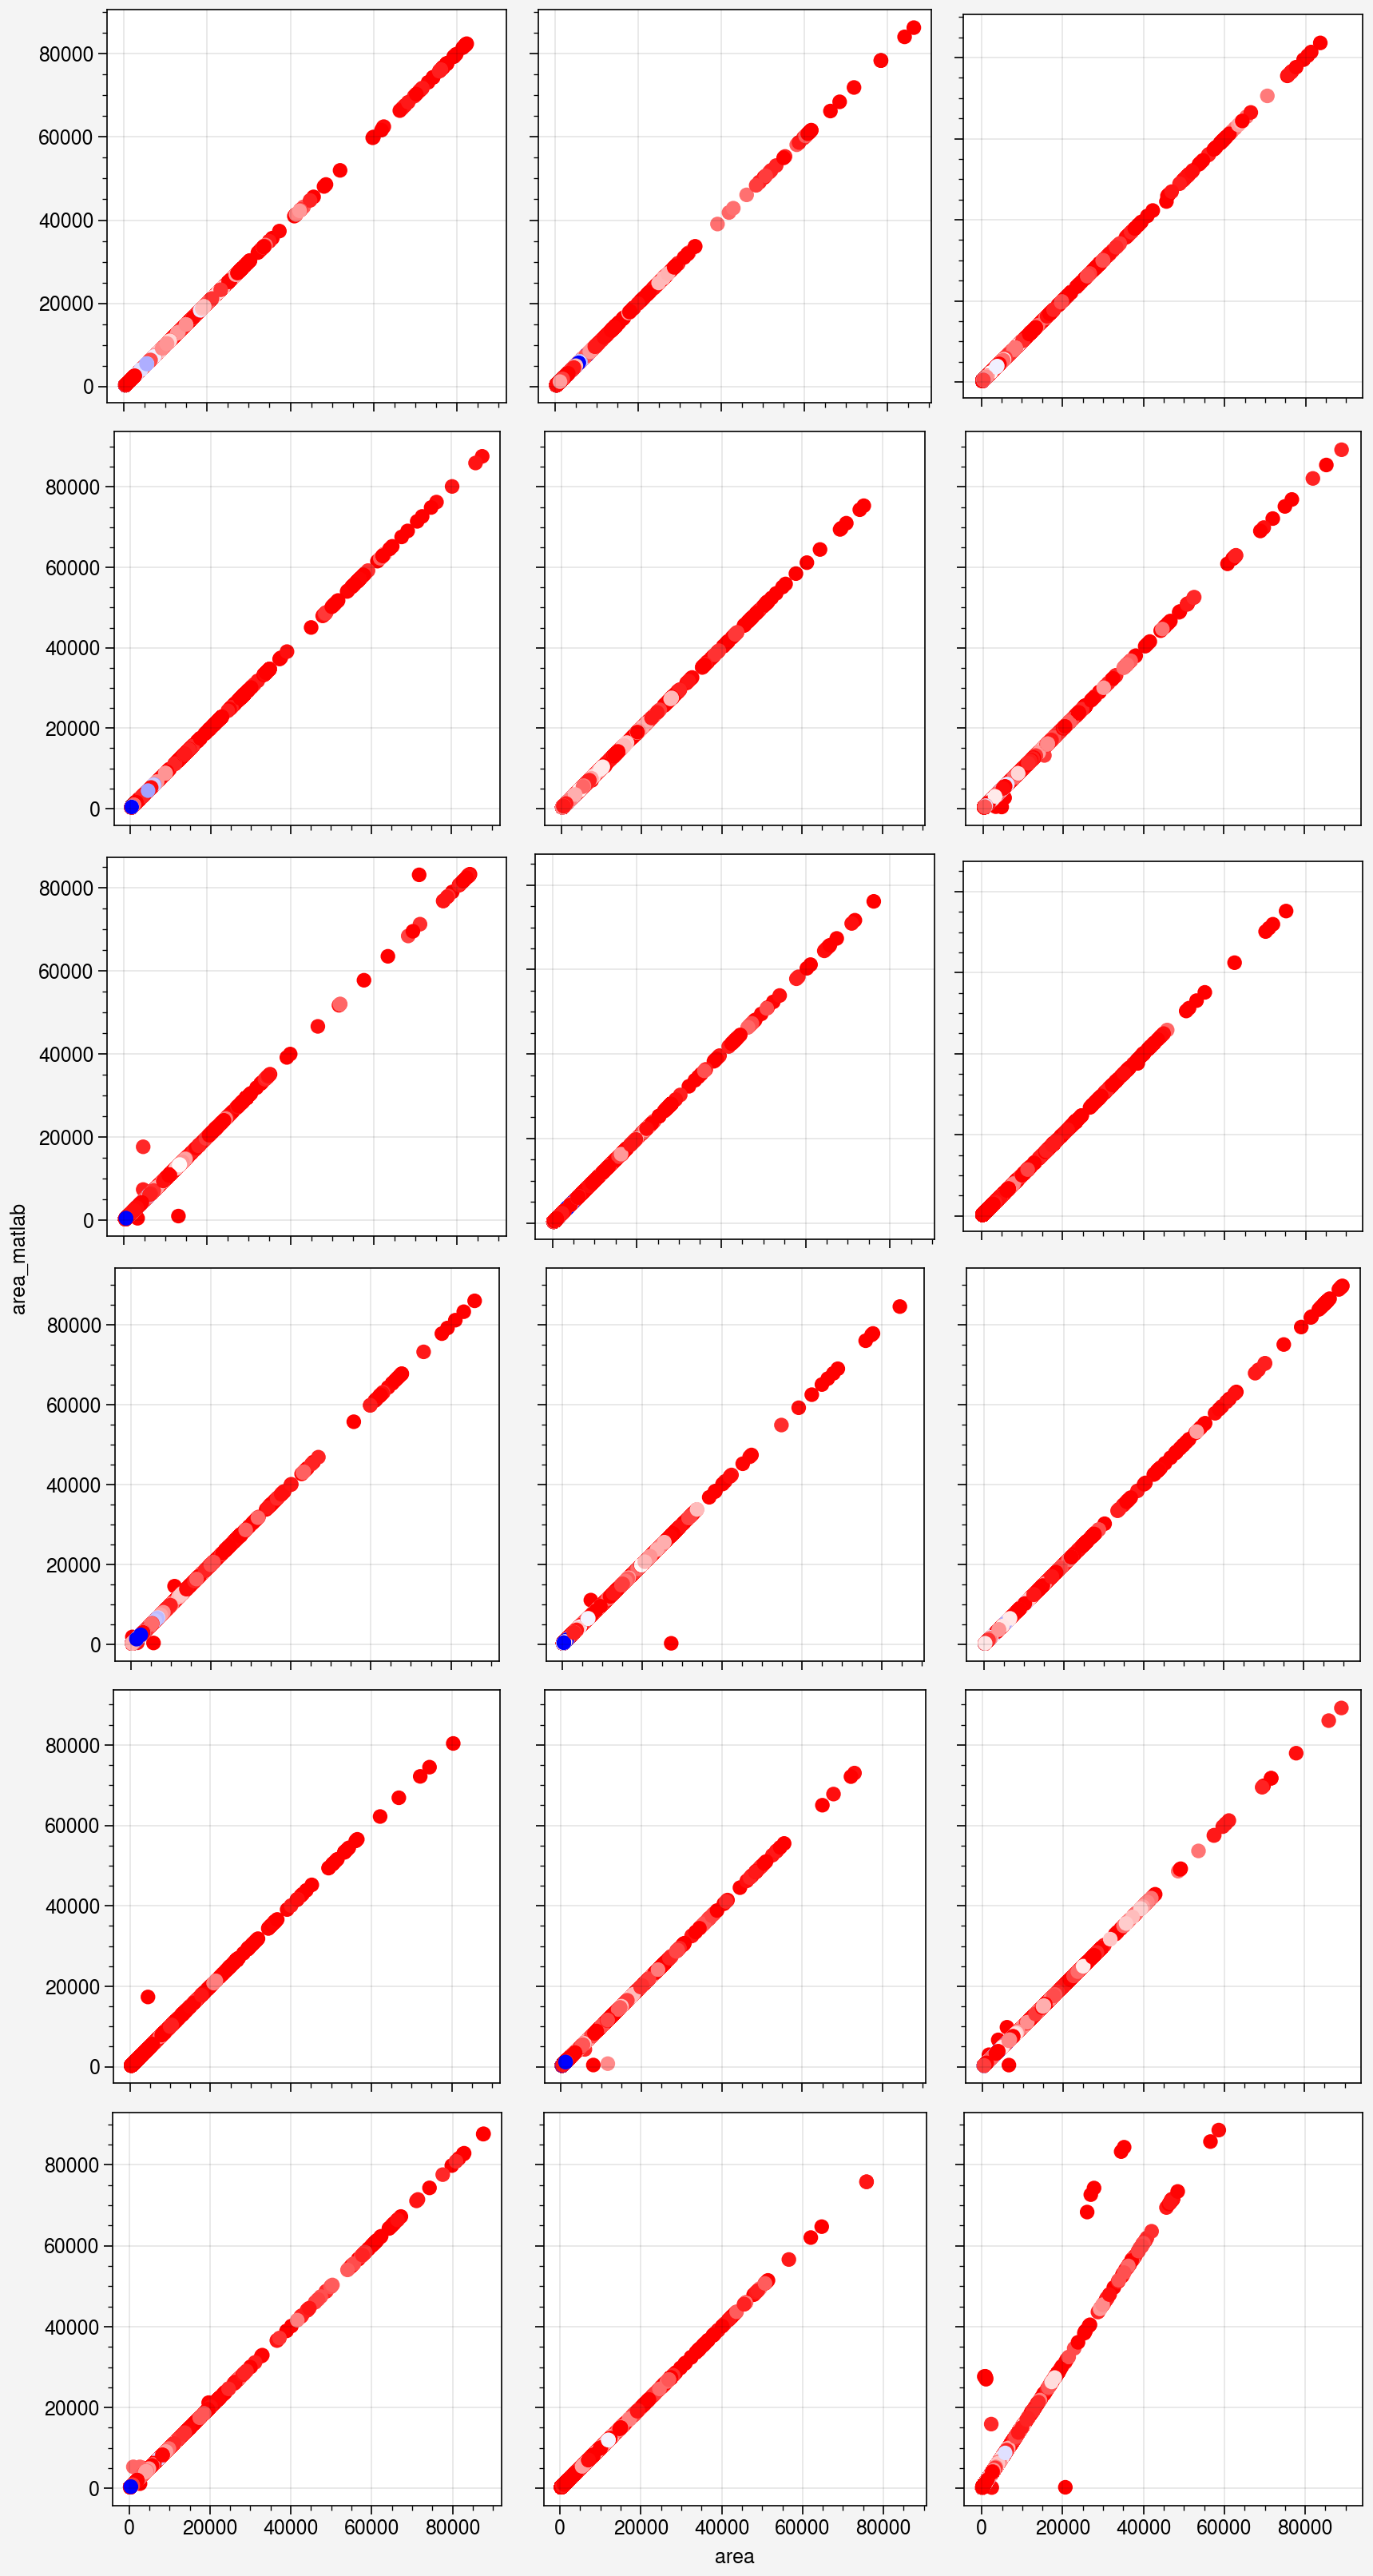

In [5]:
fig, axs = pplt.subplots(aspect=1, ncols=3, nrows=6)
for ax, year in zip(axs, ift_dfs):
    df_test = ift_dfs[year].loc[ift_dfs[year]['lr_classification'].fillna(False) & (ift_dfs[year]['nsidc_sic'] <= 1), :]
    df_test = df_test.loc[df_test.floe_id != 'unmatched']
    ax.scatter(df_test.area, df_test.area_matlab, c=df_test.nsidc_sic, cmap='bwr', vmin=0, vmax=1)

In [6]:
df_test.loc[np.abs(df_test.area - df_test.area_matlab) > 1000].shape

(21067, 36)

In [5]:
print('1st (99th) percentile floe area (pixels)')
for year in ift_dfs:
    print(year,
          ift_dfs[year].area.quantile([0.01]).values[0].astype(int),
          ift_dfs[year].area.quantile([0.99]).values[0].astype(int),
          )

1st (99th) percentile floe area (pixels)
2003 304 8294
2004 303 6634
2005 303 6933
2006 303 6025
2007 303 7510
2008 303 8798
2009 303 9065
2010 303 6954
2011 303 5079
2012 304 7019
2013 303 8189
2014 304 7720
2015 303 5738
2016 303 7128
2017 304 8911
2018 303 6322
2019 303 9341
2020 302 8130


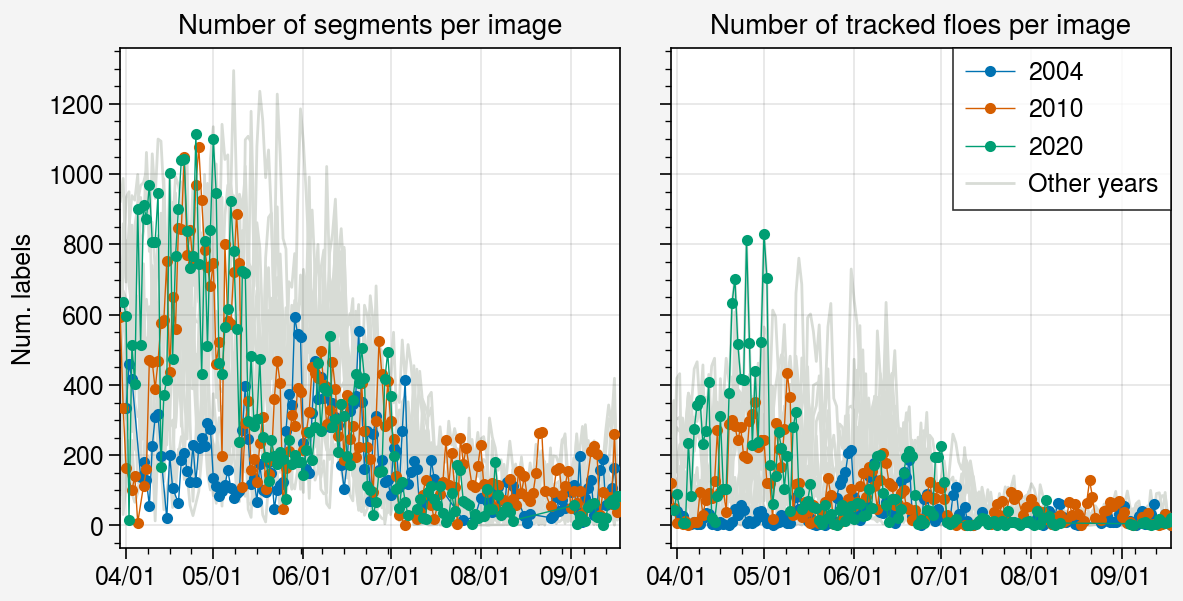

In [7]:
import warnings
warnings.simplefilter('ignore')
fig, ax = pplt.subplots(ncols=2)
for year in ift_dfs:
    dftest = ift_dfs[year].loc[(ift_dfs[year].area_matlab >= 300)]
    dates = pd.to_datetime(pd.to_timedelta(dftest.groupby(dftest.datetime.dt.dayofyear).count().index - 1, unit='day') + pd.to_datetime('{y}-01-01'.format(y=year)))
    if year in [2004, 2010, 2020]:
        ax[0].plot(dftest.groupby(dftest.datetime.dt.dayofyear).count()['label'], lw=0.5, marker='.', label=year, zorder=20)
    else:
        ax[0].plot(dftest.groupby(dftest.datetime.dt.dayofyear).count()['label'], lw=1, marker='', label='', color='light gray', zorder=0)
dates = pd.date_range('{y}-04-01'.format(y=year),
                       '{y}-10-01'.format(y=year), freq='1MS')
ax.format(xformatter=[d.strftime('%m/%d') for d in dates], xlocator=[d.dayofyear for d in dates], xlabel='', ylabel='Num. labels')
ax[0].format(title='Number of segments per image')

for year in ift_dfs:
    dftest = ift_dfs[year].loc[(ift_dfs[year].area_matlab >= 300) & (ift_dfs[year].floe_id != 'unmatched')]
    dates = pd.to_datetime(pd.to_timedelta(dftest.groupby(dftest.datetime.dt.dayofyear).count().index - 1, unit='day') + pd.to_datetime('{y}-01-01'.format(y=year)))
    if year in [2004, 2010, 2020]:
        ax[1].plot(dftest.groupby(dftest.datetime.dt.dayofyear).count()['label'], lw=0.5, marker='.', label=year, zorder=20)
    else:
        ax[1].plot(dftest.groupby(dftest.datetime.dt.dayofyear).count()['label'], lw=1, marker='', label='', color='light gray', zorder=0)
ax[1].plot(dftest.groupby(dftest.datetime.dt.dayofyear).count()['label'], lw=1, marker='', label='Other years', color='light gray', zorder=0)        
dates = pd.date_range('{y}-04-01'.format(y=year),
                       '{y}-10-01'.format(y=year), freq='1MS')
ax.format(xformatter=[d.strftime('%m/%d') for d in dates], xlocator=[d.dayofyear for d in dates], xlabel='', ylabel='Num. labels')
ax[1].legend(loc='ur', ncols=1)
ax[1].format(title='Number of tracked floes per image')
# ax.format(yscale='log')

How does the number of data points for training the LR model change over time?

2003 50527.0
2004 24639.0
2005 43107.0
2006 29059.0
2007 46912.0
2008 53898.0
2009 46947.0
2010 44361.0
2011 40633.0
2012 53432.0
2013 49570.0
2014 54244.0
2015 39256.0
2016 47401.0
2017 59874.0
2018 32419.0
2019 44273.0
2020 100928.0


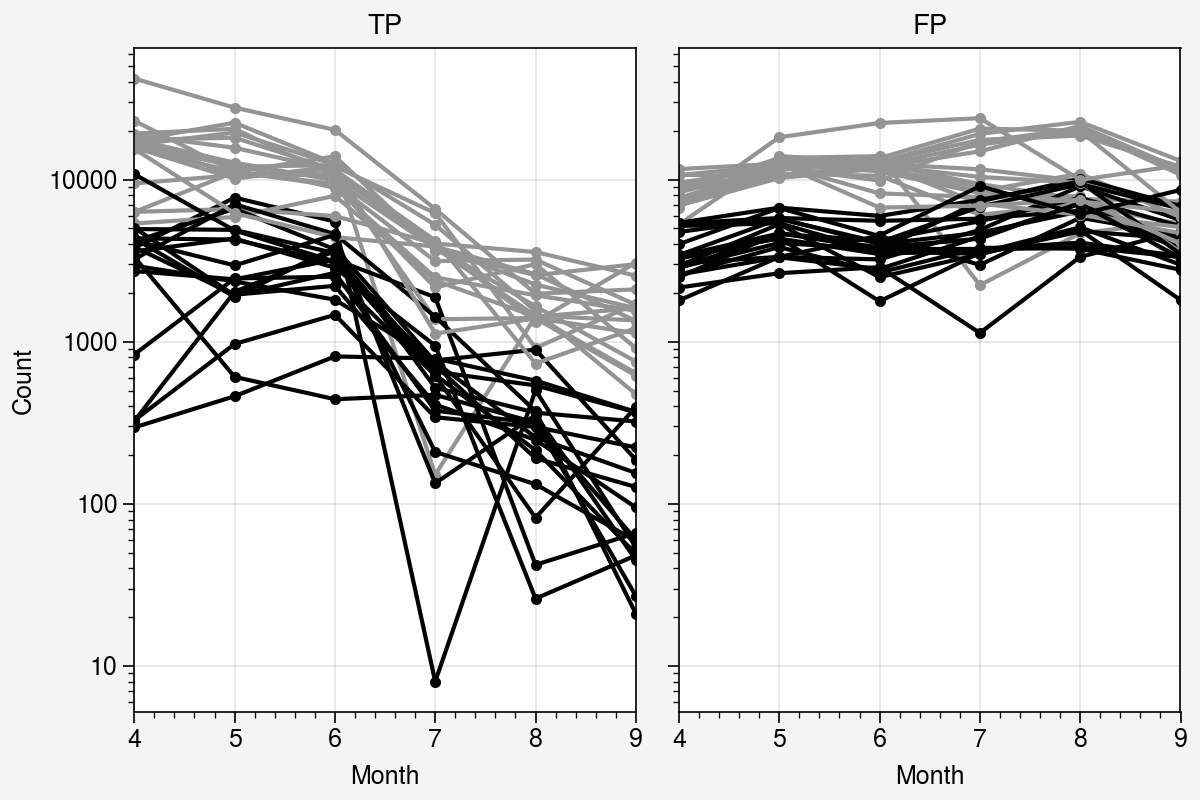

In [59]:
import warnings
warnings.simplefilter('ignore')
fig, axs = pplt.subplots(width=6, height=4, ncols=2, spanx=False)
for cls, ax in zip(['TP', 'FP'], axs):
    for year in ift_dfs:
        
        summary = ift_dfs[year].groupby([ift_dfs[year].datetime.dt.month, 'lr_classification']
                     ).count()[['floe_id']].pivot_table(index='lr_classification', values='floe_id', columns='datetime').fillna(0)
        summary = summary.loc[:, summary.columns > 3]
        if cls == 'TP':
            print(year, summary.loc[True, :].sum())
        ax.plot(summary.columns, summary.loc['T' in cls,:], marker='.', color='gray')
        
        summary = ift_dfs[year].groupby([ift_dfs[year].datetime.dt.month, 'init_classification']
                     ).count()[['floe_id']].pivot_table(index='init_classification', values='floe_id', columns='datetime').fillna(0)
        summary = summary.loc[:, summary.columns > 3]
        ax.plot(summary.columns, summary.loc[cls,:], marker='.', color='k')

        ax.format(ylabel='Count', title=cls, xlabel='Month')
        ax.format(yscale='log')

In [164]:
summary = ift_dfs[year].groupby([ift_dfs[year].datetime.dt.month, 'lr_classification']
                     ).count()[['floe_id']].pivot_table(index='lr_classification', values='floe_id', columns='datetime').fillna(0)
year

2020

In [14]:
def pixel_path_length(floe_df):
    """Calculates distance traversed in units of pixels"""
    delta_x = floe_df['x_pixel'] - floe_df['x_pixel'].shift(-1)
    delta_y = floe_df['y_pixel'] - floe_df['y_pixel'].shift(-1)
    return (np.sqrt(delta_x**2 + delta_y**2)).sum()

def estimated_mean_speed(floe_df):
    """Calculates distance traversed in units of pixels"""
    delta_x = floe_df['x_stere'] - floe_df['x_stere'].shift(-1)
    delta_y = floe_df['y_stere'] - floe_df['y_stere'].shift(-1)
    dt = (floe_df['datetime'].max() - floe_df['datetime'].min()).total_seconds()
    return np.round((np.sqrt(delta_x**2 + delta_y**2)).sum()/dt, 3)

(array([5.541e+03, 8.720e+02, 9.560e+02, 3.050e+02, 2.740e+02, 1.360e+02,
        1.210e+02, 6.700e+01, 6.200e+01, 4.500e+01, 5.300e+01, 2.100e+01,
        9.000e+00, 9.000e+00, 8.000e+00, 3.000e+00, 1.000e+00, 4.000e+00]),
 array([ 1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5, 11.5,
        12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5]),
 <BarContainer object of 18 artists>)

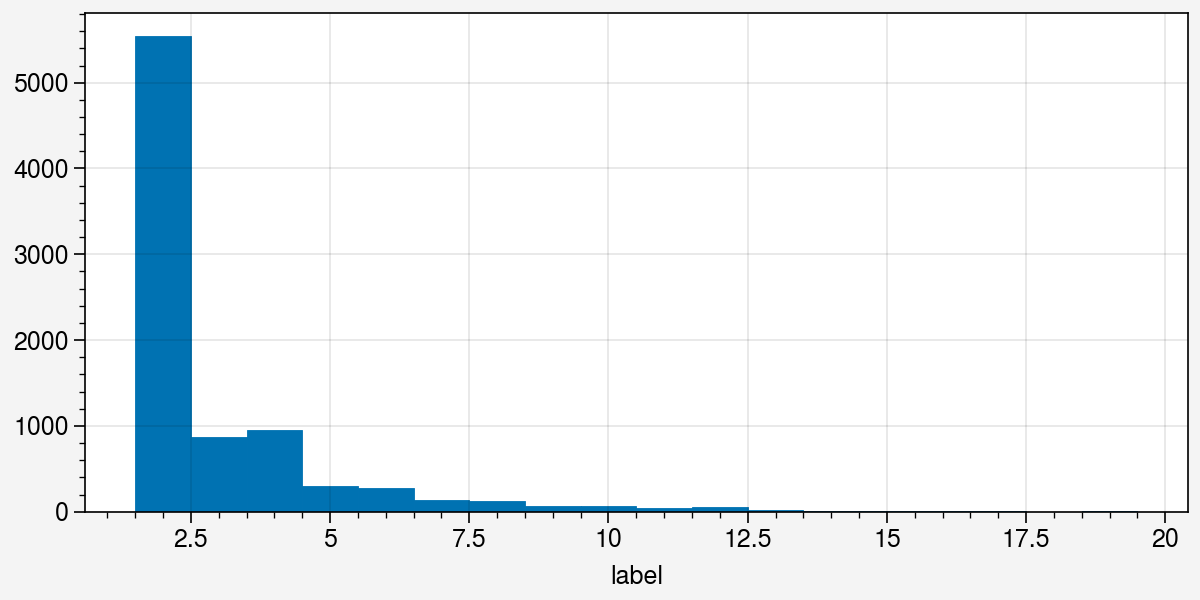

In [15]:
fig, ax = pplt.subplots(width=6, height=3)
ax.hist(ift_dfs[2020].loc[ift_dfs[2020].floe_id != 'unmatched'].groupby('floe_id').count()['label'], bins=np.arange(1.5, 20))

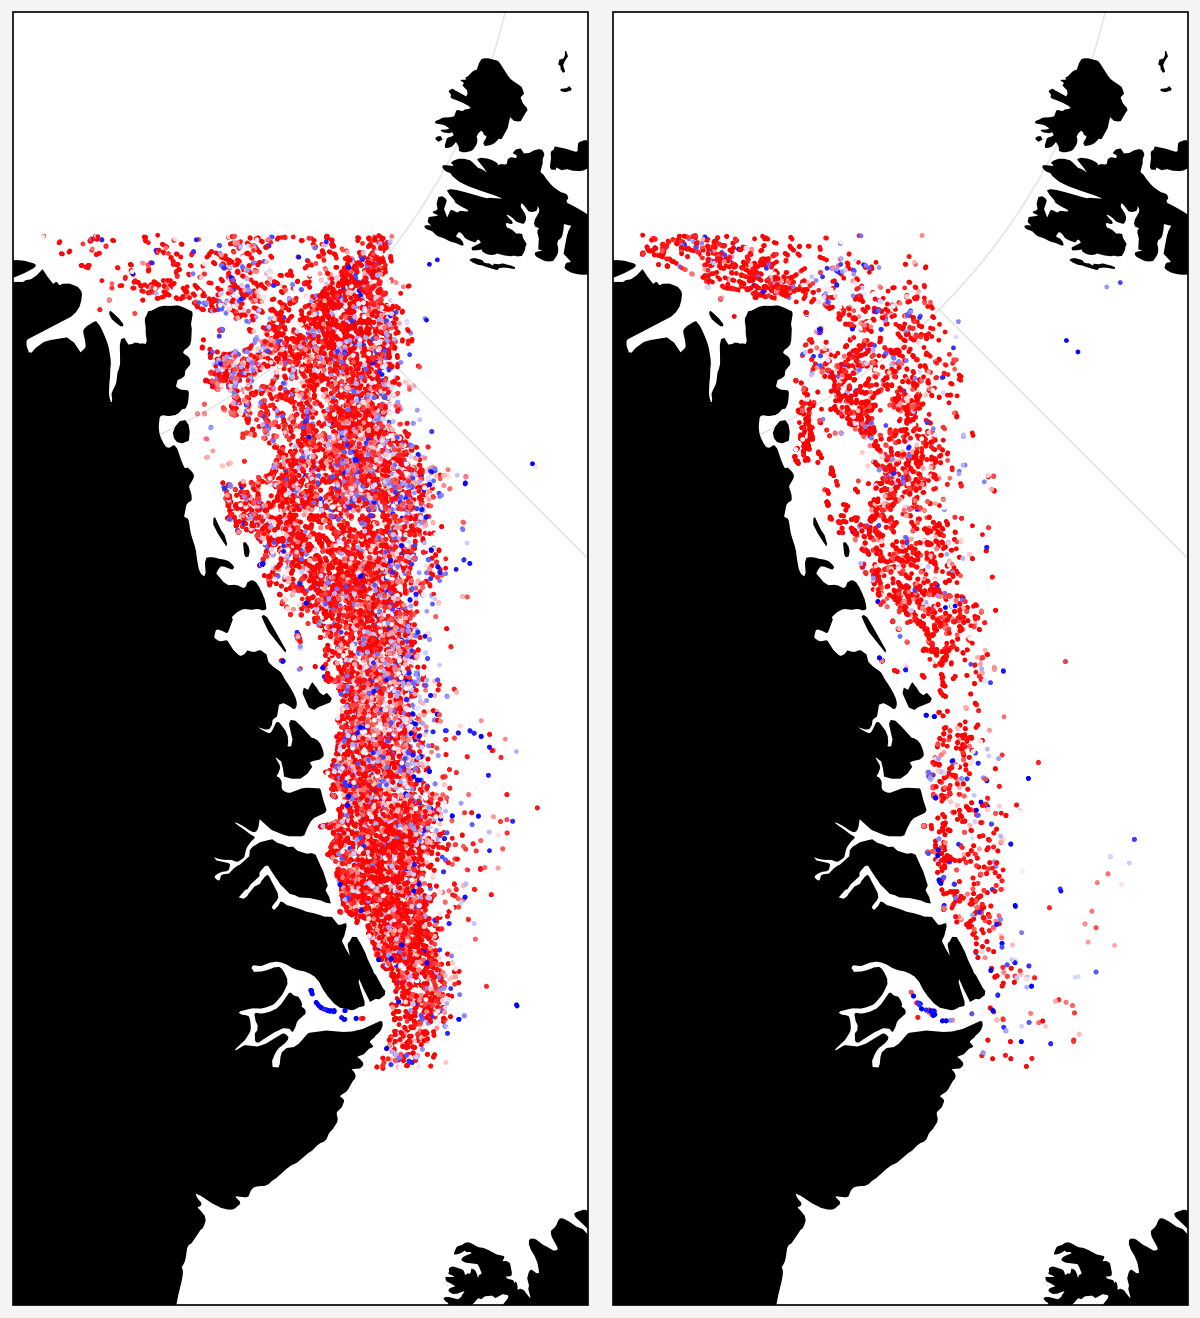

In [61]:
import cartopy.crs as ccrs
pplt.rc['cartopy.circular'] = False
pplt.rc['reso'] = 'med'
crs = ccrs.NorthPolarStereo(central_longitude=-45, true_scale_latitude=70)

fig, axs = pplt.subplots(width=6, proj='npstere', proj_kw={'lon_0': -45}, ncols=2)
axs.format(land=True, landzorder=0)
axs.set_extent([0.2e6, 1.2e6, -2.5e6, -0.25e6], crs=crs)
for year, ax in zip([2003, 2004], axs):
    df = ift_dfs[year].loc[ift_dfs[year].floe_id != 'unmatched']
    ax.scatter(df.x_stere.values, df.y_stere.values, marker='.', ms=5, c=df.lr_probability, cmap='bwr', transform=crs)


In [153]:
est_speeds = {}
for year in ift_dfs:
    df = ift_dfs[year].loc[ift_dfs[year].floe_id != 'unmatched']
    est_speeds[year] = df.groupby('floe_id').apply(estimated_mean_speed)

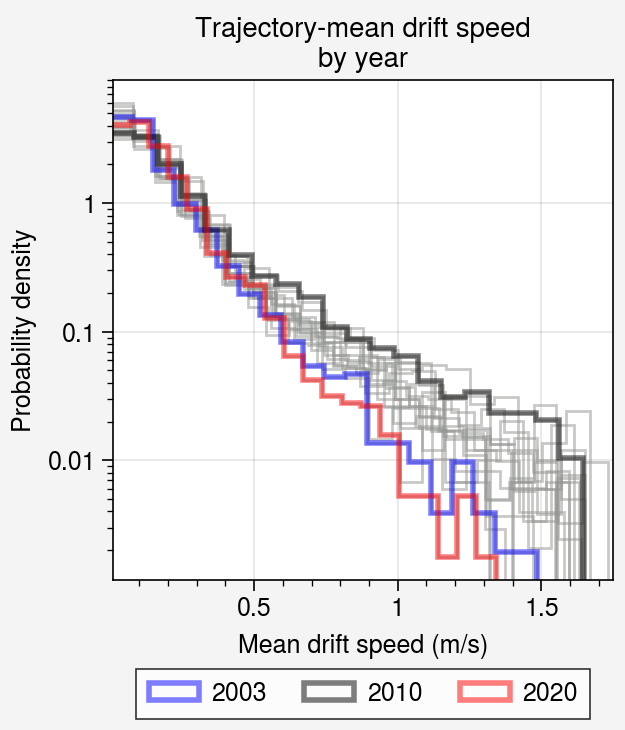

In [159]:
fig, ax = pplt.subplots()
for year in est_speeds:
    ax.hist(est_speeds[year].loc[est_speeds[year] < 10], bins=20,
            alpha=0.5, label='', density=True, histtype='step', lw=1, color='gray')

ax.format(yscale='log', xlim=(0.01, 1.75))
for color, year in zip(['b', 'k', 'r'], [2003, 2010, 2020]):
    ax.hist(est_speeds[year].loc[est_speeds[year] < 10], bins=20,
            alpha=0.5, label=year, density=True, histtype='step', lw=2, color=color)
ax.legend(loc='b')    
ax.format(title='Trajectory-mean drift speed\nby year',
          xlabel='Mean drift speed (m/s)', ylabel='Probability density')

Our next challenge is to investigate the cause of the mismatch in the estimated floe shapes. This will help us find out where the property tables and the floe libraries are not in the same order. For example, it may be that on some days the data from aqua and terra are processed in a different order.

Another possibility is that the shapes are pretty accurate, but that the method for area calculation for the wonky cloud shapes is different.

We'll look at this by choosing a specific date that contains a large difference in area.

In [28]:

df = ift_dfs[2020].copy()
df['area_mismatch'] = df['area'] - df['area_matlab']
df['perimeter_mismatch'] = df['perimeter'] - df['perimeter_matlab']

In [67]:
df.loc[np.abs(df.area - df.area_matlab) > 20000, ['datetime', 'label', 'area', 'area_matlab', 'area_mismatch', 'perimeter', 'perimeter_matlab']].sort_values('area_mismatch')[::-1]


,datetime,label,area,area_matlab,area_mismatch,perimeter,perimeter_matlab
84322,2020-05-22 13:49:26,189,112507.0,83844.0,28663.0,2902.2,4632.776
45054,2020-04-28 11:43:13,697,21424.0,260.0,21164.0,764.5,65.616
44581,2020-04-27 13:55:36,197,21364.0,777.0,20587.0,1022.5,114.924
108713,2020-06-09 13:37:10,471,20658.0,277.0,20381.0,923.7,70.570
5899,2020-04-04 13:49:46,228,38538.0,58564.0,-20026.0,1342.2,1560.312
...,...,...,...,...,...,...,...
43779,2020-04-27 12:38:20,318,26051.0,68332.0,-42281.0,1547.5,1515.358
44502,2020-04-27 13:55:36,108,26955.0,72636.0,-45681.0,1688.3,1558.050
45323,2020-04-28 11:43:13,356,27758.0,74273.0,-46515.0,1513.9,1493.412
108090,2020-06-09 12:19:48,162,34469.0,83285.0,-48816.0,2292.4,2277.042


In [46]:
date = '2020-05-22 13:49:26'
df_test = df.loc[df.datetime == date].copy()


In [59]:
comparison_index = 84322
variables = ['area', 'area_matlab', 'perimeter', 'perimeter_matlab']
df_diff = df_test.loc[:, variables] - df_test.loc[comparison_index, 'perimeter_matlab']

In [60]:
np.abs(df_diff).sort_values('perimeter')

,area,area_matlab,perimeter,perimeter_matlab
84322,107874.224,79211.224,1730.576,0.000
83873,49020.224,74634.224,2475.776,2109.850
84180,41915.224,66015.224,2903.676,2591.962
84069,19903.224,30717.224,2959.976,2673.946
84179,31781.224,50712.224,3212.876,2938.890
...,...,...,...,...
83900,4507.776,4425.776,4591.576,4581.368
83902,4508.776,4423.776,4591.776,4580.930
83915,4506.776,4422.776,4591.776,4581.856
84080,4518.776,4423.776,4592.076,4579.822


In [25]:
trajectories = {}
for year in range(2003, 2021):
    trajectories[year] = pd.read_csv(dataloc + 'fram_strait-{y}/ift_interp_floe_trajectories_{y}.csv'.format(y=year), index_col=0)


/opt/miniconda3/envs/ift_annals/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "


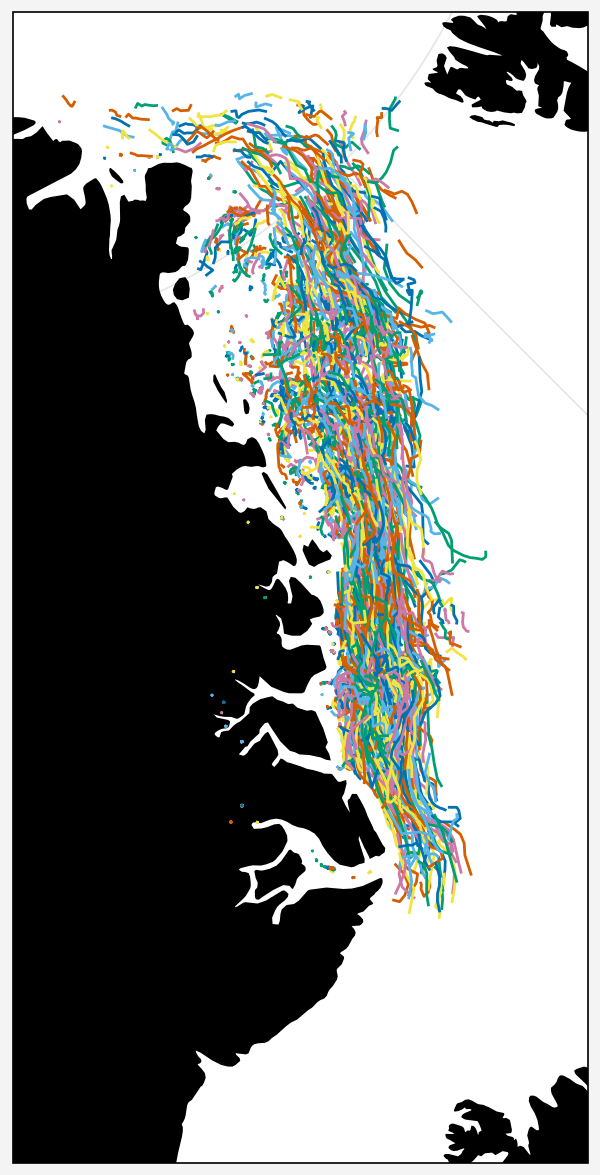

In [46]:
fig, axs = pplt.subplots(width=3, proj='npstere', proj_kw={'lon_0': -45}, ncols=1)
axs.format(land=True, landzorder=0)
axs.set_extent([0.2e6, 1.2e6, -2.5e6, -0.5e6], crs=crs)
for year in trajectories:
    df = trajectories[year]
    for floe_id, group in df.groupby('floe_id'):
        if floe_id != 'unmatched':
            if len(group) > 5:
                axs.plot(group.x_stere.values, group.y_stere.values, transform=crs, marker='', lw=1)

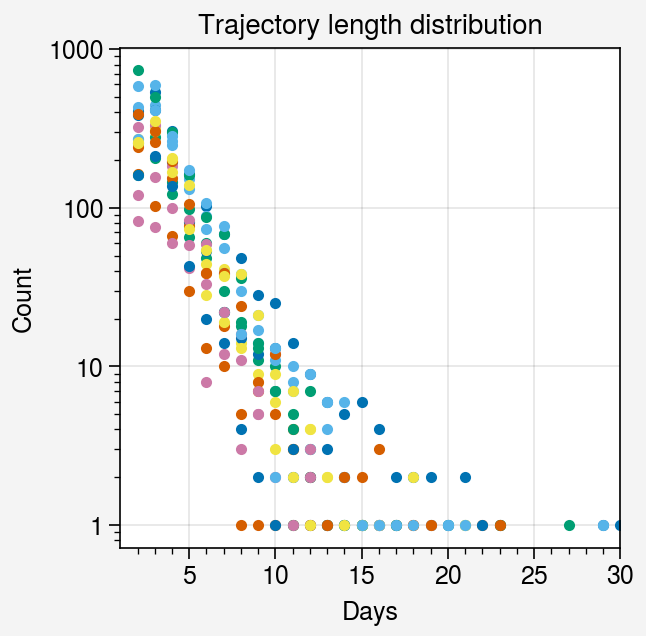

In [48]:
fig, ax = pplt.subplots()
for year in trajectories:
    df = trajectories[year]
    data, bins = np.histogram(df.groupby('floe_id').apply(lambda x: len(x), include_groups=False), bins=np.arange(1.5, 45, 1))
    lengths = np.arange(2, 45)
    ax.plot(lengths, data, marker='.', lw=0)
    ax.format(yscale='log')
ax.format(title='Trajectory length distribution', ylabel='Count', xlabel='Days')
ax.format(xlim=(1, 30))

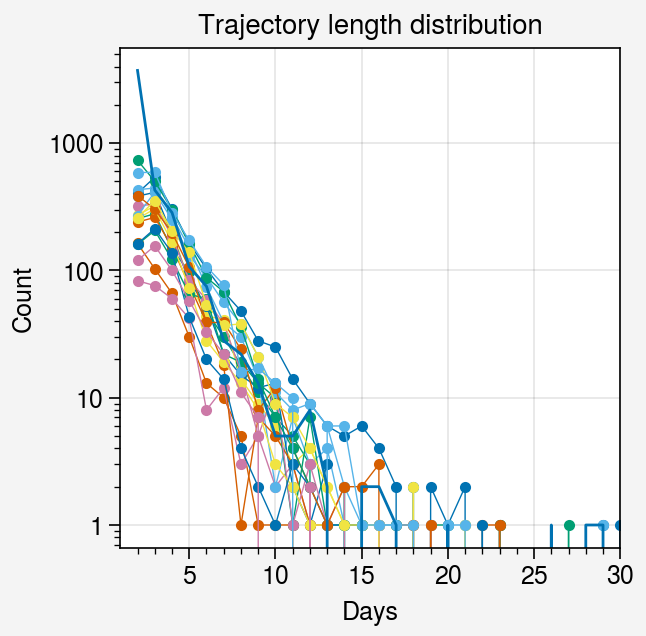

In [74]:
fig, ax = pplt.subplots()
for year in trajectories:
    df = trajectories[year]
    data, bins = np.histogram(df.groupby('floe_id').apply(lambda x: len(x), include_groups=False), bins=np.arange(1.5, 45, 1))
    lengths = np.arange(2, 45)
    ax.plot(lengths, data, marker='.', lw=0.5)
    ax.format(yscale='log')
data, bins = np.histogram(df_data2.loc[df_data2.floe_id != 'unmatched'].groupby('floe_id').apply(lambda x: len(x)), bins=np.arange(1.5, 45, 1))
ax.plot(lengths, data, lw=1)
ax.format(title='Trajectory length distribution', ylabel='Count', xlabel='Days')
ax.format(xlim=(1, 30))

In [17]:
logbins = np.logspace(np.log(10), np.log(500), base=np.e, num=10)

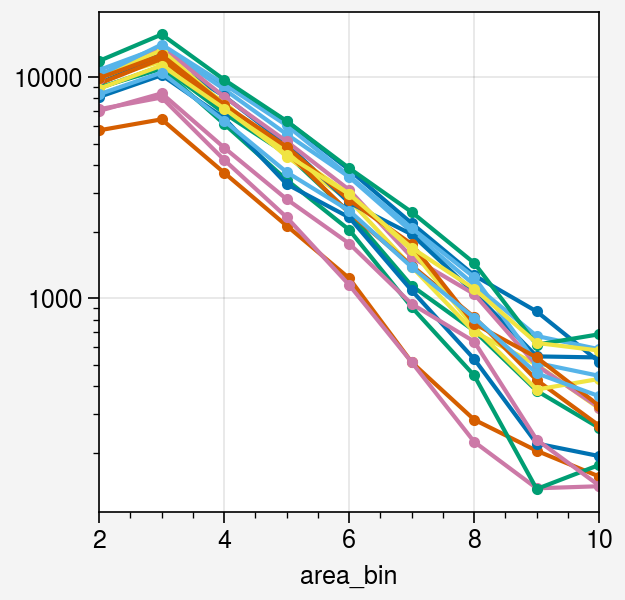

In [32]:
fig, ax = pplt.subplots()
for year in ift_dfs:
    ift_dfs[year]['area_km'] = ift_dfs[year]['area']*0.25**2
    ift_dfs[year]['area_bin'] = np.digitize(ift_dfs[year]['area_km'], bins=logbins)
    ax.plot(ift_dfs[year][['area', 'area_bin']].groupby('area_bin').count(), marker='.')
    ax.format(yscale='log')

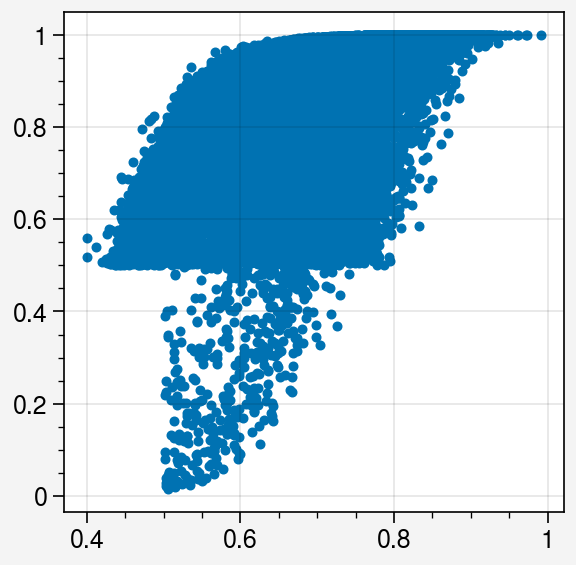

In [25]:
fig, ax = pplt.subplots()
ax.scatter(ift_dfs[year]['circularity'].values,
           ift_dfs[year]['lr_probability'].values, marker='.')

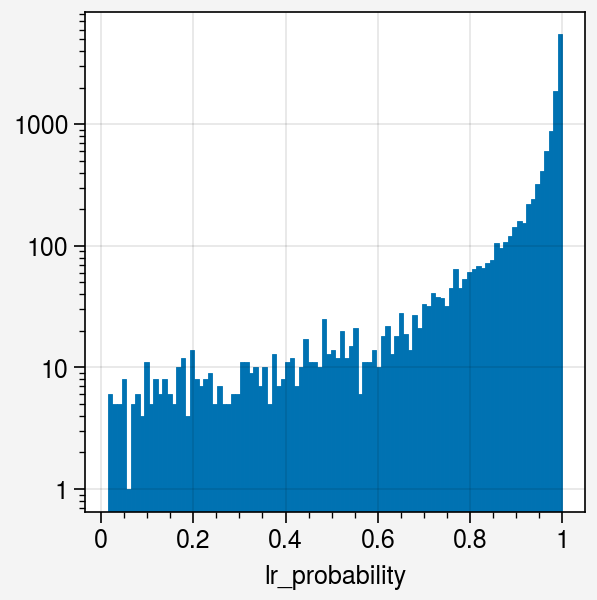

In [31]:
fig, ax = pplt.subplots()
_ = ax.hist(ift_dfs[year].loc[ift_dfs[year]['init_classification'] == 'TP', 'lr_probability'], bins=100)
ax.format(yscale='log')

In [34]:
ift_dfs[2015]

,Unnamed: 0,datetime,satellite,floe_id,label,longitude,latitude,x_stere,y_stere,col_pixel,...,tc_channel1,tc_channel2,fc_channel0,fc_channel1,fc_channel2,init_classification,lr_probability,lr_classification,area_km,area_bin
0,3,2015-04-01 12:48:38,terra,unmatched,110,-12.7338,74.6690,891722.7,-1412410.0,2515.673179,...,209.4,211.6,65.4,218.3,225.0,NA,0.829,True,35.1875,3
1,4,2015-04-01 12:48:38,terra,unmatched,111,-15.9497,73.1055,894908.4,-1611117.4,2528.117162,...,217.0,219.2,10.8,225.9,231.8,NA,0.988,True,37.8750,4
2,5,2015-04-01 12:48:38,terra,unmatched,112,-14.1843,73.8890,899758.2,-1508420.2,2547.061728,...,208.4,211.6,8.4,215.7,222.9,NA,0.739,True,25.3125,3
3,6,2015-04-01 12:48:38,terra,unmatched,113,-15.6240,73.0765,905626.0,-1608801.9,2569.982713,...,220.0,221.7,13.0,228.2,233.6,NA,0.920,True,47.0000,4
4,7,2015-04-01 12:48:38,terra,unmatched,115,-18.9672,70.5488,933399.3,-1910979.3,2678.472081,...,222.6,227.3,5.2,227.4,234.7,NA,0.597,True,24.6250,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32435,93890,2015-09-18 12:07:24,aqua,unmatched,19,-17.7256,79.5272,521276.8,-1011064.2,1068.618868,...,225.6,226.1,72.0,228.9,236.5,NA,0.530,True,33.1250,3
32436,93895,2015-09-18 12:07:24,aqua,unmatched,14,-6.7382,82.4770,505355.6,-640768.1,1006.426434,...,243.7,235.3,99.0,239.8,246.8,NA,0.954,True,75.1875,5
32437,93935,2015-09-18 12:07:24,aqua,unmatched,107,4.2702,80.7012,764952.5,-658656.2,2020.476744,...,232.3,230.7,133.9,233.3,240.0,NA,0.819,True,37.6250,4
32438,93949,2015-09-18 12:07:24,aqua,unmatched,74,-16.8949,76.5242,690755.1,-1293391.5,1730.643293,...,196.8,190.9,27.4,206.3,214.1,NA,0.987,True,20.5000,2


In [40]:
import pandas as pd
dataloc = '/Volumes/Research/ENG_Wilhelmus_Shared/group/IFT_fram_strait_dataset/'

ift_dfs = {}
for year in range(2003, 2010):
    ift_dfs[year] = pd.read_csv(dataloc + 'fram_strait-{y}/ift_raw_floe_properties_{y}.csv'.format(y=year))
    ift_dfs[year]['init_classification'] = ift_dfs[year]['init_classification'].fillna('NA')
    ift_dfs[year]['datetime'] = pd.to_datetime(ift_dfs[year].datetime.values)
    
check_y, check_x = -1996809,744026

/var/folders/_1/dv6d0pjn20bgy9ysl0pfsbr40000gn/T/ipykernel_16369/2603329475.py:6: DtypeWarning: Columns (37) have mixed types. Specify dtype option on import or set low_memory=False.
  ift_dfs[year] = pd.read_csv(dataloc + 'fram_strait-{y}/ift_raw_floe_properties_{y}.csv'.format(y=year))


In [17]:
date = '2003-05-13 14:08:02'
df = ift_dfs[2003].copy()
df = df.loc[df.datetime == date]

In [19]:
d = ((df.x_stere - check_x)**2 + (df.y_stere - check_y)**2)**0.5
print(d.min())
df.loc[d < 14e3, ['x_stere', 'y_stere', 'area', 'circularity', 'tc_channel0', 'fc_channel0', 'lr_probability']]

13532.833523323854


,x_stere,y_stere,area,circularity,tc_channel0,fc_channel0,lr_probability
38211,754616.1,-1988383.6,28219.0,0.2,235.8,0.9,0.175


In [20]:
df.loc[38211,:]

Unnamed: 0                           38211
datetime               2003-05-13 14:08:02
satellite                            terra
floe_id                         2003_01581
label                                  125
longitude                         -24.2176
latitude                           70.5487
x_stere                           754616.1
y_stere                         -1988383.6
col_pixel                      1980.100181
row_pixel                      5282.188065
area                               28219.0
perimeter                           1332.2
solidity                          0.416824
orientation                        1.12046
circularity                            0.2
axis_major_length                    524.2
axis_minor_length                    185.9
bbox_min_row                          5089
bbox_min_col                          1807
bbox_max_row                          5367
bbox_max_col                          2260
area_matlab                        28219.0
perimeter_m

0.3911167245782725
0.012


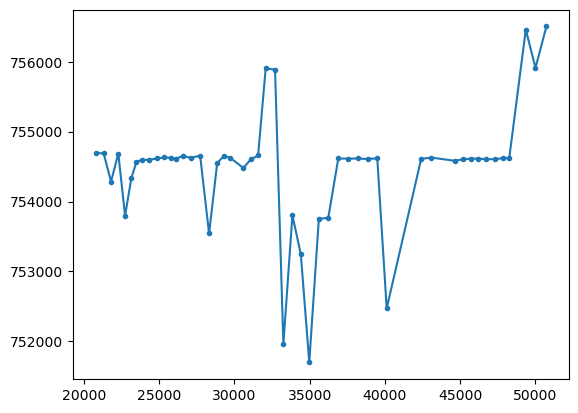

In [29]:
import numpy as np
def pixel_path_length(floe_df):
    """Calculates distance traversed in units of pixels"""
    delta_x = floe_df['col_pixel'] - floe_df['col_pixel'].shift(-1)
    delta_y = floe_df['row_pixel'] - floe_df['row_pixel'].shift(-1)
    return (np.sqrt(delta_x**2 + delta_y**2)).median()

def estimated_mean_speed(floe_df):
    """Calculates distance traversed in units of pixels"""
    delta_x = floe_df['x_stere'] - floe_df['x_stere'].shift(-1)
    delta_y = floe_df['y_stere'] - floe_df['y_stere'].shift(-1)
    dt = (floe_df['datetime'].max() - floe_df['datetime'].min()).total_seconds()
    return np.round((np.sqrt(delta_x**2 + delta_y**2)).sum()/dt, 3)
floe_df = ift_dfs[2003].loc[ift_dfs[2003].floe_id == '2003_01581']
floe_df.x_stere.plot(marker='.')
print(pixel_path_length(floe_df))
print(estimated_mean_speed(floe_df))

In [44]:
pls = ift_dfs[2009].groupby('floe_id').apply(pixel_path_length)

/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/var/folders/_1/dv6d0pjn20bgy9ysl0pfsbr40000gn/T/ipykernel_16369/2075811523.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the ope

In [45]:
pls.quantile([0.01, 0.99])

0.01     0.075154
0.99    78.172995
dtype: float64